<a href="https://colab.research.google.com/github/AaronXu9/FASTAI_projects/blob/main/FastAI_02_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 13.7 MB/s 
     |████████████████████████████████| 1.2 MB 26.5 MB/s 
     |████████████████████████████████| 189 kB 59.0 MB/s 
     |████████████████████████████████| 46 kB 3.1 MB/s 
     |████████████████████████████████| 56 kB 3.7 MB/s 
     |████████████████████████████████| 51 kB 340 kB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
#collect data
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

In [4]:
urls = search_images_ddg('grizzly bear', max_images=100)
len(urls),urls[0]

(100,
 'https://media.spokesman.com/photos/2017/11/30/Yellowstone_Grizzlies.JPG.jpg')

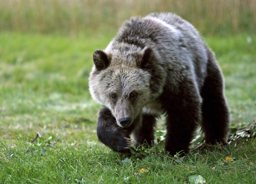

In [5]:
download_url(urls[0], 'images/bear.jpg')
im = Image.open('images/bear.jpg')
im.thumbnail((256,256))
im

In [6]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        print(f'{o} bear')
        results = search_images_ddg(f'{o} bear')
        download_images(dest, urls=results)

grizzly bear
black bear
teddy bear


In [7]:
#check the path
fns = get_image_files(path)
fns

(#818) [Path('bears/black/00000140.jpg'),Path('bears/black/00000114.JPG'),Path('bears/black/00000262.JPG'),Path('bears/black/00000049.jpg'),Path('bears/black/00000152.jpg'),Path('bears/black/00000126.png'),Path('bears/black/00000085.jpg'),Path('bears/black/00000027.jpg'),Path('bears/black/00000131.jpg'),Path('bears/black/00000248.jpg')...]

In [8]:
#remove the corrupted images downloaded 
failed = verify_images(fns)
failed

(#6) [Path('bears/teddy/00000094.jpg'),Path('bears/teddy/00000003.jpg'),Path('bears/teddy/00000054.jpg'),Path('bears/teddy/00000072.png'),Path('bears/teddy/00000278.jpg'),Path('bears/teddy/00000268.jpg')]

In [9]:
failed.map(Path.unlink)

(#6) [None,None,None,None,None,None]

**from Data to Dataloaders**

In [10]:
#convert data to dataloader that splits the data into train and validation 
bears = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms=Resize(128)
)

In [11]:
#datablock serves as a template for the actual data
dls = bears.dataloaders(path)

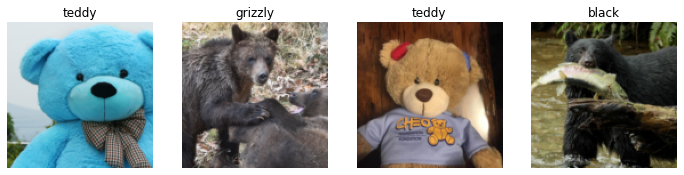

In [12]:
dls.valid.show_batch(max_n = 4, nrows = 1)

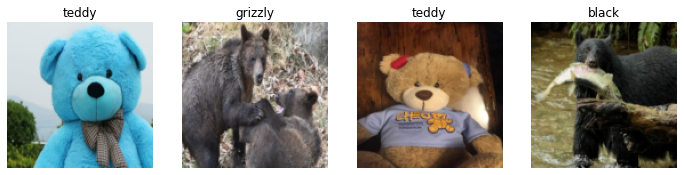

In [13]:
#Resize usually crops the images to fit a square shape of the size. We can pad the images with zeros or squish/stretch them
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n = 4, nrows = 1)

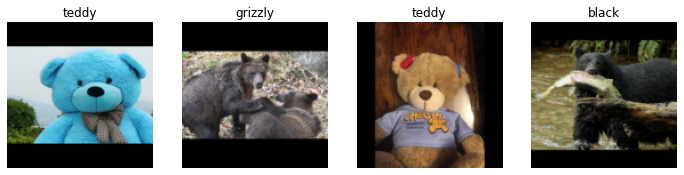

In [14]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode = 'zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n = 4, nrows = 1)

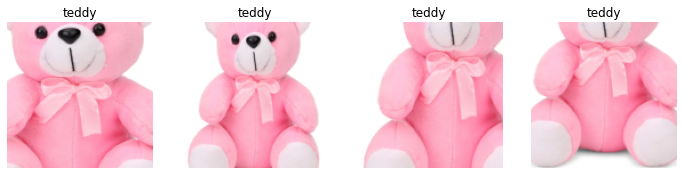

In [15]:
#Either crop or squish or padding will affect the quality of the imagse. Therefore we could randomly crop the images and use one of them in each epoch. 
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale = 0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


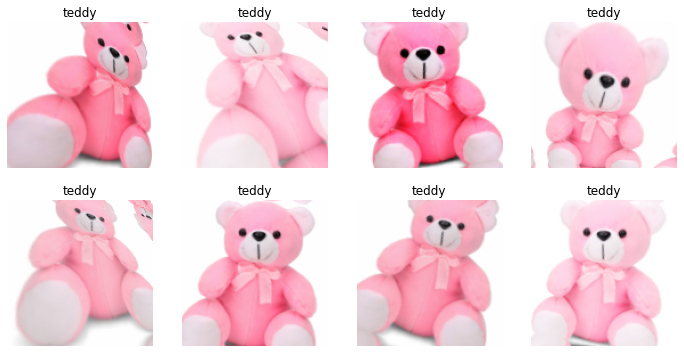

In [16]:
#data augmentation (rotation, flipping, perspective warping, brightness changes and contrast changes)
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n = 8, nrows = 2, unique=True)


In [17]:
doc(aug_transforms)

In [18]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [19]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.849831,0.124170,0.024691,00:38


epoch,train_loss,valid_loss,error_rate,time
0,0.111258,0.136969,0.043210,00:38
1,0.094433,0.120907,0.043210,00:38
2,0.079482,0.108798,0.043210,00:38
3,0.068465,0.125616,0.043210,00:38


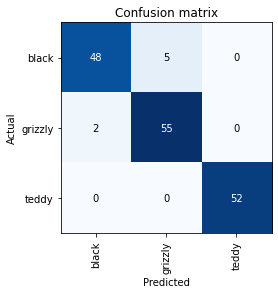

In [20]:
#plot the confusion matrix to see misclassified samples
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

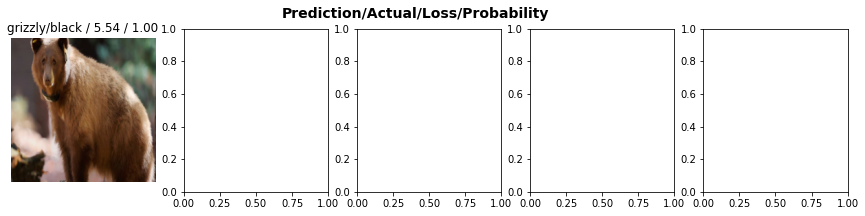

In [22]:
#Plot the images with the highest loss in the dataset
interp.plot_top_losses(5, nrows = 1)

In [23]:
#clear the wrongly-labeled samples 
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

**use the model for predictions (known as inference)**

In [24]:
learn_inf = load_learner(path/'export.pkl')

In [32]:
learn_inf.predict('images/bear.jpg')

('grizzly', TensorBase(1), TensorBase([1.1371e-02, 9.8863e-01, 1.5013e-06]))

In [27]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [30]:
#create a notebook app from the model
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [35]:
btn_upload = SimpleNamespace(data = ['images/bear.jpg'])

In [36]:
img = PILImage.create(btn_upload.data[-1])

In [37]:
#use output widge to display it 
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [40]:
pred, pred_idx, probs = learn_inf.predict(img)

In [41]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9886')

In [42]:
#need a button to do the classification
btn_run = widgets.Button(desciption='Classify')
btn_run

Button(style=ButtonStyle())

In [43]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [44]:
btn_upload = widgets.FileUpload()

In [45]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

**Turn the notebook into a real App**

In [49]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     |████████████████████████████████| 1.7 MB 3.8 MB/s 
     |████████████████████████████████| 129 kB 44.9 MB/s 
     |████████████████████████████████| 556 kB 34.9 MB/s 
     |████████████████████████████████| 111 kB 52.5 MB/s 
     |████████████████████████████████| 396 kB 49.6 MB/s 
     |████████████████████████████████| 78 kB 8.1 MB/s 
     |████████████████████████████████| 53 kB 2.5 MB/s 
     |████████████████████████████████| 428 kB 49.8 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: pip's dependency resolver does

Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?


**Deploy the Model** 